In [1]:
import trimesh

scene = trimesh.Scene()

In [ ]:
# read /home/s94zalek_hpc/shape_matching/data/SHREC16_test/null/off/david.off
import os

scene.geometry.clear()

base_folder = '/home/s94zalek_hpc/shape_matching/data_sign_training/train/test_partial_simpleCuts/off'

mesh_files = os.listdir(base_folder)

# choose 10 random meshes
import numpy as np

mesh_files = np.random.choice(mesh_files, 10, replace=False)

for i, mesh_file in enumerate(mesh_files):
    mesh = trimesh.load_mesh(f'{base_folder}/{mesh_file}', process=False)
    
    mesh.fix_normals()
    # alternatively, validate=True when creating Trimesh object
    
    mesh.vertices += [i, 0, 0]
    
    scene.add_geometry(mesh)
    
scene.show()

In [ ]:
# read /home/s94zalek_hpc/shape_matching/data/SHREC16_test/null/off/david.off
import os

scene.geometry.clear()

mesh_files = os.listdir('/home/s94zalek_hpc/shape_matching/data/SHREC16_test/null/off')

for i, mesh_file in enumerate(mesh_files):
    mesh = trimesh.load_mesh(f'/home/s94zalek_hpc/shape_matching/data/SHREC16_test/null/off/{mesh_file}', process=False)
    
    mesh.fix_normals()
    # alternatively, validate=True when creating Trimesh object
    
    print(f'{mesh_file}: area_faces = {mesh.area_faces.sum()}')
    
    mesh.vertices += [i, 0, 0]
    
    scene.add_geometry(mesh)
    
scene.show()

In [ ]:
# read /home/s94zalek_hpc/shape_matching/data/SHREC16_test/null/off/david.off
import os

scene.geometry.clear()

mesh_files = sorted(os.listdir('/home/s94zalek_hpc/shape_matching/data/SHREC16_test/holes/off'))
# print(mesh_files)

for i, mesh_file in enumerate(mesh_files):
    
    if 'david' not in mesh_file:
        i -= 1
        continue
    
    print(f'{i}) {mesh_file},', end=' ')
    
    mesh = trimesh.load_mesh(f'/home/s94zalek_hpc/shape_matching/data/SHREC16_test/holes/off/{mesh_file}',
                             process=False, validate=True)
    
    print(f'area_faces: {mesh.area_faces.sum()}')
    
    mesh.fix_normals()
    
    mesh.vertices += [i, 0, 0]
    
    scene.add_geometry(mesh)
    
scene.show()

In [2]:
import my_code.datasets.shape_dataset as shape_dataset

dataset = shape_dataset.PairShrec16Dataset(
    'data/SHREC16_test/',
    categories=[
        'david', 'michael', 'victoria'
    ],
    cut_type='holes', return_faces=True,
    return_evecs=True, num_evecs=200,
    return_corr=True, return_dist=False
)

In [3]:
import my_code.diffusion_training_sign_corr.data_loading as data_loading

single_dataset, pair_dataset = data_loading.get_val_dataset(
    'SHREC16_holes_pair', phase='test', num_evecs=200, preload=False, return_evecs=200
    )

In [20]:
idx = 59

data = pair_dataset[idx]

print(data['second']['name'])
print(data['first']['corr'], data['second']['corr'])

In [21]:
import my_code.utils.plotting_utils as plotting_utils
import matplotlib.pyplot as plt
import torch


C_gt_xy_lstsq = torch.linalg.lstsq(
    data['second']['evecs'][data['second']['corr']],
    data['first']['evecs'][data['first']['corr']]
    ).solution

C_gt_yx_lstsq = torch.linalg.lstsq(
    data['first']['evecs'][data['first']['corr']],
    data['second']['evecs'][data['second']['corr']]
    ).solution
        
print(C_gt_xy_lstsq.min(), C_gt_xy_lstsq.max())
print(C_gt_yx_lstsq.min(), C_gt_yx_lstsq.max())        

l = 0
h = 64

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

plotting_utils.plot_Cxy(fig, axs[0],  C_gt_xy_lstsq,
                        'before', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_gt_yx_lstsq,
                        'before', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], C_gt_xy_lstsq.T - C_gt_yx_lstsq,
                        'before', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[3], C_gt_xy_lstsq.T.abs() - C_gt_yx_lstsq.abs(),
                        'before', l, h, show_grid=False, show_colorbar=False)
plt.show()

In [6]:
# TODO: does scaling affect the fmap?

In [ ]:
import torch

scene.geometry.clear()

for evec_n in range(1, 9):
    
    mesh_1 = trimesh.Trimesh(data['first']['verts'] + torch.tensor([0, evec_n, 0]),
                             data['first']['faces'],
                            validate=True
                            )
    mesh_2 = trimesh.Trimesh(data['second']['verts'] + torch.tensor([1, evec_n, 0]),
                             data['second']['faces'],
                            validate=True
                            )

    cmap_1 = trimesh.visual.color.interpolate(
        torch.nn.functional.normalize(data['first']['evecs'][:, evec_n], p=2, dim=0),
        'bwr')
    cmap_2 = trimesh.visual.color.interpolate(
        torch.nn.functional.normalize(data['second']['evecs'][:, evec_n], p=2, dim=0)
        , 'bwr')

    mesh_1.visual.vertex_colors = cmap_1[:len(mesh_1.vertices)]
    mesh_2.visual.vertex_colors = cmap_2[:len(mesh_2.vertices)]

    scene.add_geometry(mesh_1)
    scene.add_geometry(mesh_2)

scene.show()

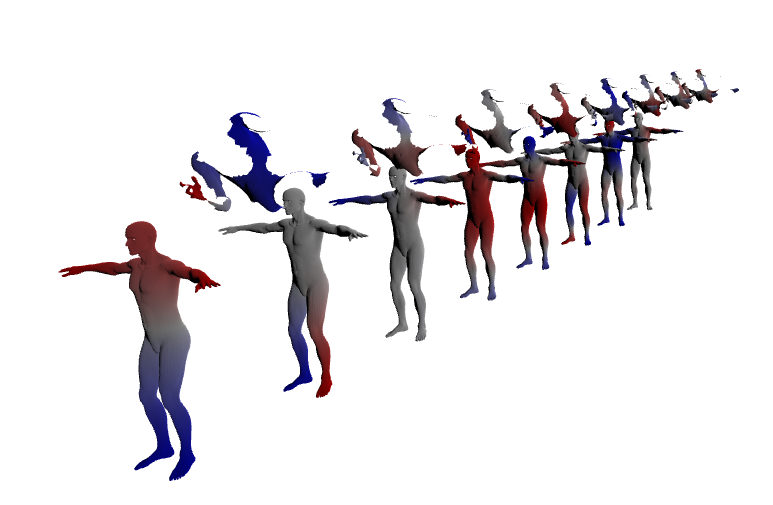

# Regularized calculation of Cxy

In [158]:
import my_code.diffusion_training_sign_corr.test.test_diffusion_pair_template_unified as test_diffusion

fmnet = test_diffusion.RegularizedFMNet(
)  

In [159]:
evecs_first = data['first']['evecs']
evecs_second = data['second']['evecs']

evals_first = data['first']['evals']
evals_second = data['second']['evals']

num_evecs = 200

p2p_first = data['first']['corr']
p2p_second = data['second']['corr']

evecs_trans_first = data['first']['evecs_trans']
evecs_trans_second = data['second']['evecs_trans']
        
Cxy_reg = fmnet.compute_functional_map(
    evecs_trans_second[:num_evecs, p2p_second].unsqueeze(0),
    evecs_trans_first[:num_evecs, p2p_first].unsqueeze(0),
    evals_second[:num_evecs].unsqueeze(0),
    evals_first[:num_evecs].unsqueeze(0), 
)[0].T

Cyx_reg = fmnet.compute_functional_map(
    evecs_trans_first[:num_evecs, p2p_first].unsqueeze(0),
    evecs_trans_second[:num_evecs, p2p_second].unsqueeze(0),
    evals_first[:num_evecs].unsqueeze(0),
    evals_second[:num_evecs].unsqueeze(0),  
)[0].T

In [172]:
import my_code.utils.plotting_utils as plotting_utils
import matplotlib.pyplot as plt


C_gt_xy_lstsq = torch.linalg.lstsq(
    data['second']['evecs'][data['second']['corr']],
    data['first']['evecs'][data['first']['corr']]
    ).solution

C_gt_yx_lstsq = torch.linalg.lstsq(
    data['first']['evecs'][data['first']['corr']],
    data['second']['evecs'][data['second']['corr']]
    ).solution
                

l = 0
h = 64

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

plotting_utils.plot_Cxy(fig, axs[0],  C_gt_xy_lstsq,
                        'Cxy', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_gt_yx_lstsq,
                        'Cyx', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], Cxy_reg,
                        'before', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[3], 
                        torch.linalg.pinv(Cxy_reg),
                        # Cyx_reg,
                        'before', l, h, show_grid=False, show_colorbar=False)
plt.show()

In [7]:
import utils.fmap_util as fmap_util

p2p_xy = fmap_util.fmap2pointmap(
    C12=C_gt_xy_lstsq,
    evecs_x=evecs_first[:, :num_evecs],
    evecs_y=evecs_second[:, :num_evecs],
    ).cpu()

p2p_yx = fmap_util.fmap2pointmap(
    C12=C_gt_xy_lstsq.T,
    evecs_x=evecs_second[:, :num_evecs],
    evecs_y=evecs_first[:, :num_evecs],
    ).cpu()

In [ ]:
import my_code.utils.plotting_utils as plotting_utils

scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    
    data['second']['verts'], data['second']['faces'],
    data['first']['verts'], data['first']['faces'],
    p2p_yx,
    axes_color_gradient=[0, 2],
    base_cmap='hsv'
)

scene.show()

# Use the transposed fmap as inverse

In [169]:
import utils.shape_util as shape_util

dist_x = torch.tensor(
    shape_util.compute_geodesic_distmat(data['first']['verts'].numpy(), data['first']['faces'].numpy())    
)
dist_y = torch.tensor(
    shape_util.compute_geodesic_distmat(data['second']['verts'].numpy(), data['second']['faces'].numpy())    
)

In [171]:
import metrics.geodist_metric as geodist_metric

corr_first = data['first']['corr']
corr_second = data['second']['corr']

geo_err = geodist_metric.calculate_geodesic_error(
    dist_y, corr_second.cpu(), corr_first.cpu(), p2p_yx, return_mean=True
)
print(geo_err)

In [ ]:
from tqdm import tqdm
import utils.fmap_util as fmap_util
import utils.shape_util as shape_util
import metrics.geodist_metric as geodist_metric

geo_err_list = []

num_evecs = 32

for i in range(len(pair_dataset)):
    data = pair_dataset[i]

    C_gt_xy_lstsq = torch.linalg.lstsq(
        data['second']['evecs'][data['second']['corr']],
        data['first']['evecs'][data['first']['corr']]
        ).solution
    
    p2p_yx = fmap_util.fmap2pointmap(
        C12=C_gt_xy_lstsq[:num_evecs,:num_evecs].T,
        evecs_x=data['second']['evecs'][:, :num_evecs],
        evecs_y=data['first' ]['evecs'][:, :num_evecs],
        ).cpu()
    
    dist_y = torch.tensor(
        shape_util.compute_geodesic_distmat(data['second']['verts'].numpy(), data['second']['faces'].numpy())    
    )
    
    geo_err = geodist_metric.calculate_geodesic_error(
        dist_y, data['second']['corr'].cpu(), data['first']['corr'].cpu(), p2p_yx, return_mean=True
    ) * 100
    
    
    geo_err_list.append(geo_err)
    print(f'{i}/{len(pair_dataset)}) {geo_err.item():.2f}')
    
    

In [12]:
torch.tensor(geo_err_list).mean(), torch.tensor(geo_err_list).median(), torch.tensor(geo_err_list).min(), torch.tensor(geo_err_list).max()

In [14]:
scene.geometry.clear()

mesh = trimesh.load_mesh('/home/s94zalek_hpc/shape_matching/data/SHREC16_test/null/off/david.off', process=False)

In [16]:
mesh.vertices = (mesh.vertices + 1) * 2

mesh.area_faces.sum()